# kaggle之房价预测实例

本篇是kaggle竞赛中的一道练习题  
https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview

## 一、对数据的初步认识

### 读取数据查看特征

In [4]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy.stats import norm
from scipy import stats
from sklearn import linear_model

df_train= DataFrame(pd.read_csv("/opt/house/train.csv"))
columns=df_train.columns
print(columns)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

为了了解数据，我们应该看一下每个值并理解其含义，知道每个值跟当前问题的关系。这是比较耗时的操作，但有利于我们理解数据集。  
对于每一个特征，我们可以试着去想一想  
1、在我们自己买房子时是否会考虑该因素？  
2、如果我们考虑该因素，那么该因素的重要程度又是怎样?  
3、各因素之间描述的信息是否冗余，由A因素可以得到B因素的信息？  
经过一系列过程，提取4个认为重要的特征  
OverallQual (整体材料和完成质量)、YearBuilt(建造时间)、TotalBsmtSF(地下室面积)、GrLivArea(地上面积即生活区面积)  

## 二、分析价格及各特征与价格之间的关系

### 看一下价格的分布

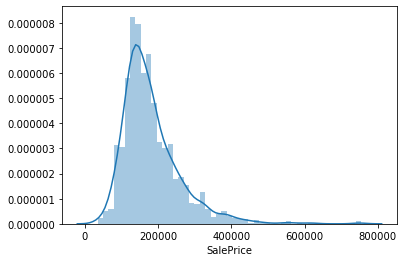

In [6]:
sns.distplot(df_train['SalePrice'])

特点：1、偏离正态分布。2、呈现正偏差（ positive skewness）。  
峰度：峰度（Kurtosis）是描述某变量所有取值分布形态陡缓程度的统计量。  
Kurtosis=0 与正态分布的陡缓程度相同。  
Kurtosis>0 比正态分布的高峰更加陡峭——尖顶峰  
Kurtosis<0 比正态分布的高峰来得平台——平顶峰  

偏度：偏度（Skewness）是描述某变量取值分布对称性的统计量。  
Skewness=0 分布形态与正态分布偏度相同  
Skewness>0 正偏差数值较大，为正偏或右偏。长尾巴拖在右边。  
Skewness<0 负偏差数值较大，为负偏或左偏。长尾巴拖在左边。  

### 下面看一下其他特征和价格的关系

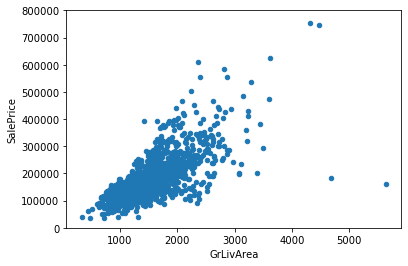

In [7]:
#居住面积和价格的关系
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

### 观察发现居住面积和价格成一种线性关系。

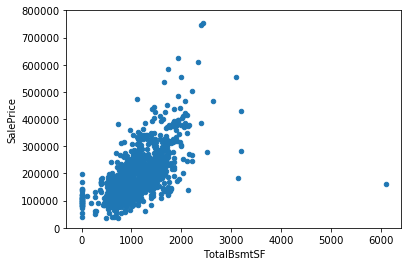

In [8]:
#地下室面积和价格的关系
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

### 地下室面积和价格似乎也称某种线性关系，而且由于有些的住宅并没有地下室，所以X轴有大量的0。

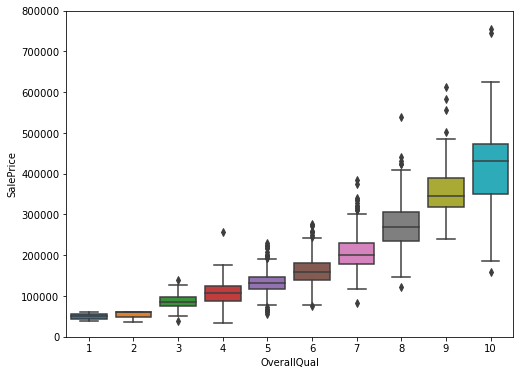

In [9]:
#整体材料和成品质量跟价格的关系（X不是连续的值，而是分为各等级的特征）
var = 'OverallQual'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

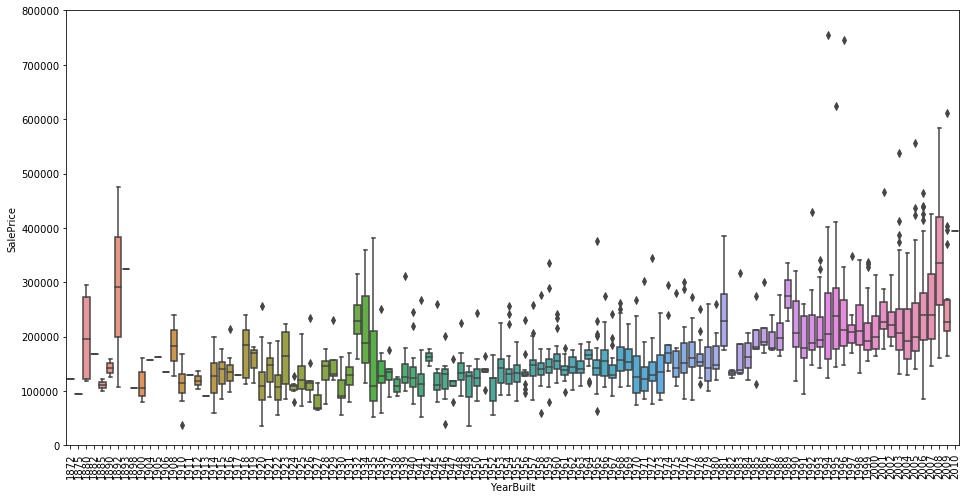

In [10]:
#建造时间和价格的关系
var = 'YearBuilt'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

虽然图表中没有呈现较强的趋势，但是一般认为新建的房屋比年代久远的要更贵。  
对上述图表做一个总结：  
1、'GrLivArea' 和 'TotalBsmtSF'对'SalePrice'呈现正线性相关的特点，随着X轴的增大，Y轴也随之增大，而且'TotalBsmtSF'的斜率似乎更大。  
2、'OverallQual' 和'YearBuilt'似乎也与'SalePrice'相关。而与'OverallQual' 的关系更大，图表表明质量等级更高的房屋，价格也会随之增加。   

### 到现在为止，我们只分析了4种特征对房屋价格的影响，但仍然还有多个特征需要我们来分析。 

## 三、客观分析，用数据说话

之前的分析都是根据我们自己所想的，特征的选择也是我们自认为重要的。所以现在我们要冷静下来，做一些客观的分析。  

### 关联矩阵(heatmap)查看各特征之间的关联程度

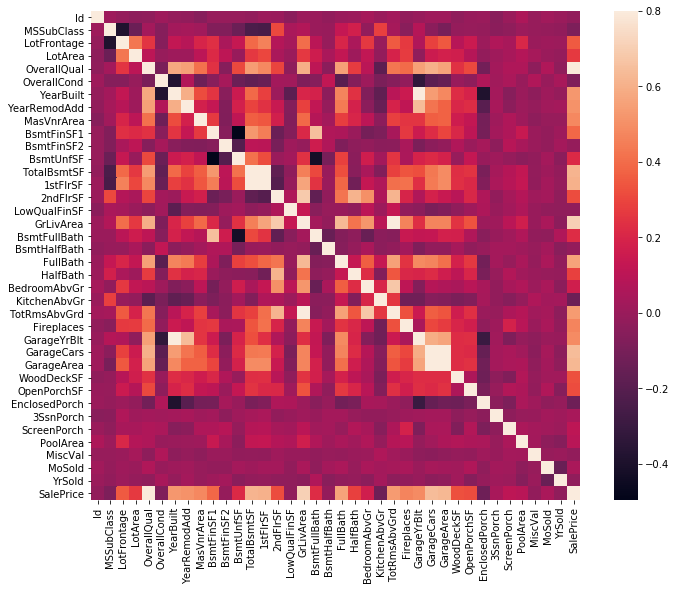

In [12]:
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

在图中（蓝色方框标出） 'TotalBsmtSF' 和'1stFlrSF'两个特征与价格的关系颜色相近，说明这两个特征之间的关联很大。同样的还有'Garage'开头的特征。这些之间关联大的特征给出的信息是很有可能是相似的。Heatmaps 是一种十分强大的方法，有助于我们观察特征以便特征选择。

### 接下来将选取与价格关联最大的特征，选取与价格关联程度最大的几个特征

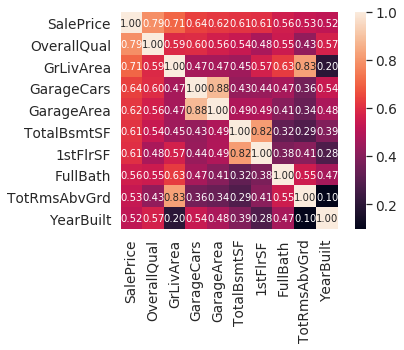

In [14]:
#价格关联矩阵
k = 10 #选择特征的数量
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

根据上图，我们可以得出：  
1、'OverallQual', 'GrLivArea'和'TotalBsmtSF' 特征与'SalePrice'呈强相关，跟我们之前的主观预测一样。  
2、'GarageCars' 和 'GarageArea'之间的关联程度很高，其传达的信息相似，所以我们只需保留一个特征。所以我们打算保留GarageCars，因为GarageCars的分数(0.64)比GarageArea(0.62)更高。  
3、'TotalBsmtSF' and '1stFloor'与第2条也是同样的道理，我们选择保留'TotalBsmtSF'。  
4、'TotRmsAbvGrd' and 'GrLivArea'也是关联程度较高的两个特征，保留'GrLivArea'。  

### 现在我们需要提取的特征有['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']，让我们看下特征之间的关系。

/opt/jupyterhub/miniconda/lib/python3.7/site-packages/seaborn/axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


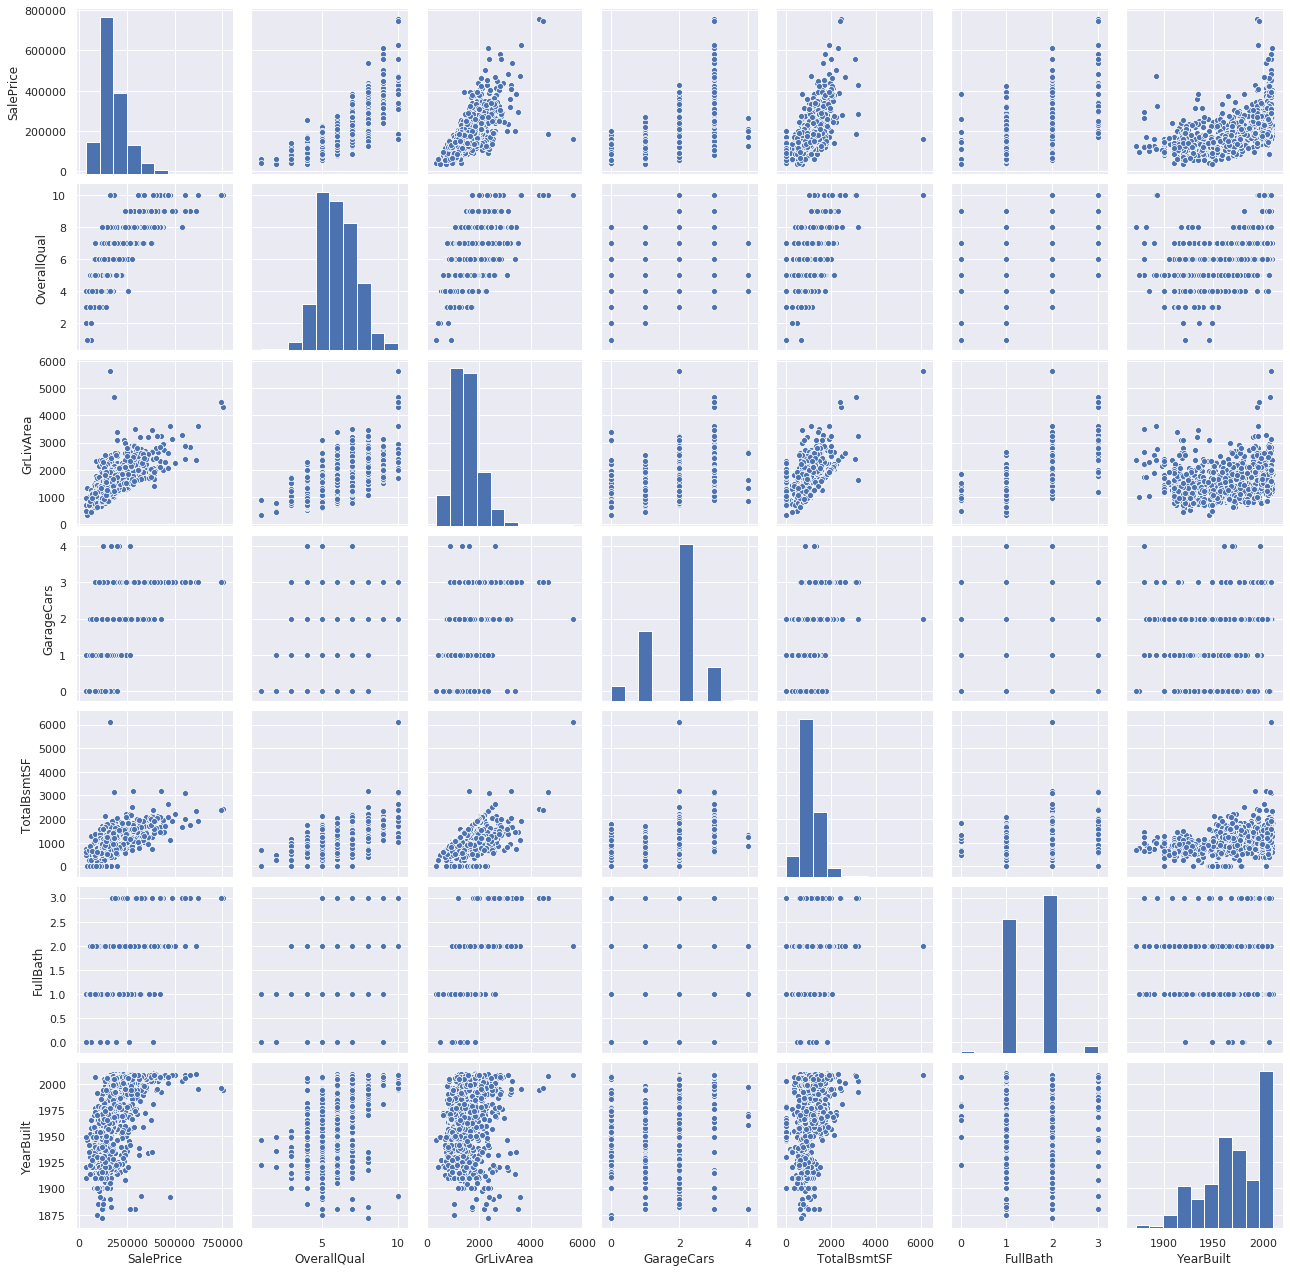

In [15]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols], size = 2.5)
plt.show()

简要分析下：  
首先看第五行第三列这幅图，X为GrLivArea，Y为TotalBsmtSF。在图中可以看到我们能够画出一条边界线，使得大部分点在该边界线下方。地下室面积最多与地上居住面积差不多，一般不会大于地上居住面积。  
第一行第七列这幅图，X为YearBuilt，Y为SalePrice。图中”点云“大部分集中在底部，但可以看到上升的趋势，并且价格在近些年增长得比较快。  

## 四、缺失数据的处理

### 通常遇到缺值的情况，我们会有几种常见的处理方式

1、如果缺值的样本占总数比例极高，我们可能就直接舍弃了，作为特征加入的话，可能反倒带入noise，影响最后的结果了  
2、如果缺值的样本适中，而该属性非连续值特征属性(比如说类目属性)，那就把NaN作为一个新类别，加到类别特征中  
3、如果缺值的样本适中，而该属性为连续值特征属性，有时候我们会考虑给定一个step(比如这里的age，我们可以考虑每隔2/3岁为一个步长)，然后把它离散化，之后把NaN作为一个type加到属性类目中。  
4、有些情况下，缺失的值个数并不是特别多，那我们也可以试着根据已有的值，拟合一下数据，补充上。  

### 现在让我们看下训练数据集中数据的损失情况

In [18]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


对于缺损数据的处理：  
1、超过15%缺失的特征，直接将其删除。  
2、以'Garage'开头的特征其缺损个数相同，猜测该特征信息可由其他特征推出。由于我们之前考虑了'GarageCars'特征，所以将'Garage'开头的缺失特征删除。同样的道理，我们已经考虑'TotalBsmtSF'特征，将'Bsmt'开头的特征删除。  
3、对于'MasVnrArea'和'MasVnrType'特征，我们认为其对于价格的影响并不大。而且'YearBuilt'和'OverallQual'这两个与价格关联较强的特征以经将其考虑进去了。所以去掉'MasVnrArea'和'MasVnrType'这两个特征。  
4、对于'Electrical'特征，因为有一条记录该值为空，所以可以只删除该条纪律，而保留'Electrical'特征。  

In [19]:
#删除上述特征和Electrical为空的那一条记录
df_train = df_train.drop((missing_data[missing_data['Total'] > 1]).index,1)
df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)
df_train.isnull().sum().max() #打印值应该为0，表明数据集中已没有空值

0

## 五、离群数据的处理

对于一些"离群值"，我们需要注意，因为这些点会影响我们的模型，可以提供宝贵的信息，有助于我们对于特定行为的认识。

### 下面来看下“居住面积”和“房屋价格”的关系

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


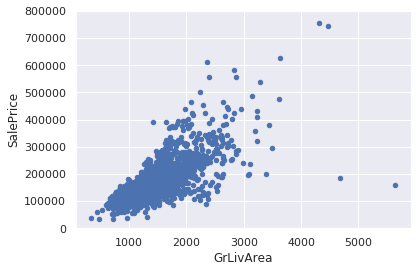

In [20]:
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

可以看到最右边的两个点，感觉很奇怪。居住面积很大，但房屋价格却不高，可能是农业用地吧。所以这两个点不能作为特征点，我们需要将其去除。

### 最上面的两个点虽然价格很高，但是符合房屋价格增长的趋势，所以将其保留。

In [21]:
#上面最右边的点
df_train.sort_values(by = 'GrLivArea', ascending = False)[:2]
df_train = df_train.drop(df_train[df_train['Id'] == 1299].index)
df_train = df_train.drop(df_train[df_train['Id'] == 524].index)

### 接下来是"地下室面积"和"房屋价格"的关系

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


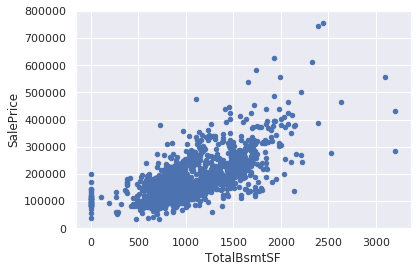

In [22]:
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

发现图中的点还是大体上符合趋势的，所以不做改变。

## 六、核心步骤

1、当谈到标准化时，我们希望数据能够呈现一种正态分布。在本次练习中，
希望'SalePrice'能够呈现正态分布，如果能够实现正态分布，可以避免很多其他问题。  
2、在上述点图中，可以看出大部分关系为线性关系。  

### 实现正态分布：

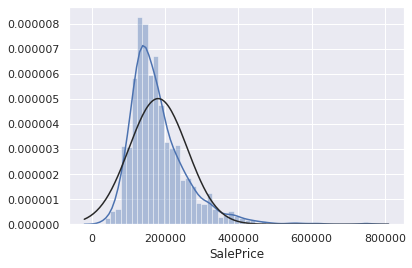

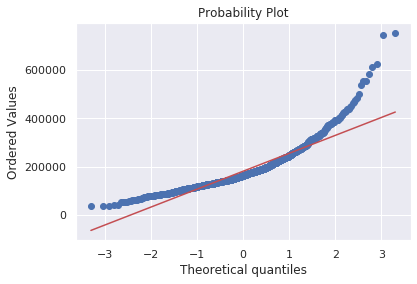

In [24]:
#histogram and normal probability plot
sns.distplot(df_train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

### 在上图中，我们可以看到房屋价格并不是呈现正态分布，而是正偏差。可以通过log转变（具体原理我也不清楚）使其分布得更接近正态分布。

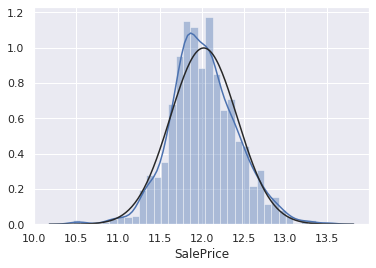

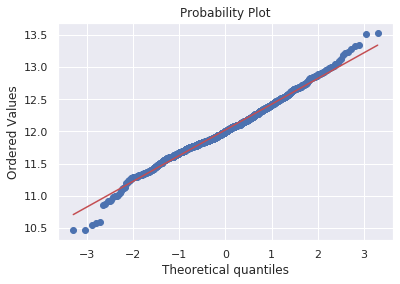

In [25]:
df_train['SalePrice'] = np.log(df_train['SalePrice'])
sns.distplot(df_train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

### 同样的道理，对'GrLivArea'特征也做log transformation，使其靠近正态分布。

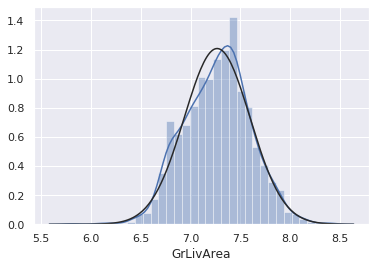

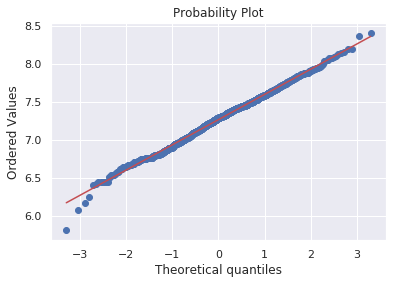

In [26]:
df_train['GrLivArea'] = np.log(df_train['GrLivArea'])
sns.distplot(df_train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['GrLivArea'], plot=plt)

### 对'TotalBsmtSF'特征也做log transformation，由于有些房屋并没有地下室面积，其值为0。如果直接跟之前一样做log transformation，会报错。先增加一列特征作为判别该房屋是否有地下室的标志。地下室面积大于0的，'HasBsmt'特征标为1，否则标为0。

In [27]:
df_train['HasBsmt'] = pd.Series(len(df_train['TotalBsmtSF']), index=df_train.index)
df_train['HasBsmt'] = 0 
df_train.loc[df_train['TotalBsmtSF']>0,'HasBsmt'] = 1

### 在对有地下室的值进行log transformation。

In [62]:
df_train.loc[df_train['HasBsmt']==1,'TotalBsmtSF'] = np.log(df_train.loc[df_train['HasBsmt']==1,'TotalBsmtSF'])
sns.distplot(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], plot=plt)

### 至此，我们终于完成了对训练集数据的处理，包括特征提取、对缺失数据、偏移数据进行删除，对房屋价格、居住面积、地下室面积标准化处理。接下来我们将搭建模型。

## 七、搭建模型

### 这次选取的模型是线性回归模型，我们之前提取的特征有  ['SalePrice','OverallQual','GrLivArea','TotalBsmtSF','GarageCars','FullBath','YearBuilt','Electrical']

In [56]:
#正则化取出所需的feature
train_df=data_train.filter(regex='SalePrice|OverallQual|GrLivArea|TotalBsmtSF|GarageCars|FullBath|YearBuilt')
train_up=train_df.values

y=train_up[:,-1].ravel()
X=train_up[:,:-1]

clf=linear_model.LinearRegression(normalize=True)
clf.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

## 八、对测试集数据进行预测

### 对测试集数据也做同样的处理

In [67]:
data_test=DataFrame(pd.read_csv("/opt/house/test.csv"))

### 对地下室面积和居住面积进行log transform，使其呈现正态分布

In [68]:
data_test["GrLivArea"] = np.log(data_test["GrLivArea"])
data_test['HasBsmt'] = pd.Series(len(data_test['TotalBsmtSF']), index=data_test.index)
data_test['HasBsmt'] = 0
data_test.loc[data_test['TotalBsmtSF']>0,'HasBsmt'] = 1
data_test.loc[data_test['HasBsmt']==1,'TotalBsmtSF'] = np.log(data_test.loc[data_test['HasBsmt']==1,'TotalBsmtSF'])

### 对空值进行赋值

In [69]:
data_test.loc[data_test['TotalBsmtSF'].isnull().index,'TotalBsmtSF']=0
data_test.loc[data_test['BsmtFullBath'].isnull(),'BsmtFullBath']=0
data_test.loc[data_test['GarageCars'].isnull(),'GarageCars']=0

### 对测试集数据进行预测

In [70]:
test_df=data_test.filter(regex='OverallQual|GrLivArea|TotalBsmtSF|GarageCars|FullBath|YearBuilt')
predictions=clf.predict(test_df)
origin_price=np.exp(predictions)
results=DataFrame({"Id":data_test["Id"].values,"SalePrice":origin_price.astype(np.float32)})
#results.to_csv("result/linear_regression_prediction.csv",index=False)

/opt/jupyterhub/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
